In [ ]:
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tqdm
import networkx as nx

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
from gensim.test.utils import datapath
from os import listdir, mkdir, remove
from os.path import isfile, join
from numpy import genfromtxt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

Результатом работы алгоритма тематичсекого моделлирования являются две матрицы: матрица термов тем и тем документов. В данной работе нас будет интересовать первое распределение: какими термами задаются темы.
* Функция term_topic позволяет извлечь из модели матрицу теромв тем и представить из в виде таблицы

In [ ]:
def term_topic(model):
  topics = [[(term, round(wt, 3)) 
                for term, wt in model.show_topic(n, topn=30)] 
                    for n in range(0, model.num_topics)]
  topics_df = pd.DataFrame([[term for term, wt in topic] 
                                for topic in topics], 
                          columns = ['Term'+str(i) for i in range(1, 31)],
                          index=['Topic '+str(t) for t in range(1, model.num_topics+1)]).T
  return topics_df

Матрицы термов тем ранжированы для каждой темы по тому, насколько вероятно, что документ, содеражщий данный терм, будет связан с конкретной темой. Такое ранжирование сообщает важную информацию о модели, однако не всегда удобно для исследования. Отсортируем матрицу в зависимости от весов TF-IDF термов, если корпус азадн таким образом, что набор термов каждой темы является в нем документом.

In [ ]:
def tfidf_corpus(bow):
  tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
  return tfidf.fit_transform([sum([[t]*q for t, q in bow_doc], []) for bow_doc in bow]).toarray()

def tfidf_sort(df):
  corpus = df.to_numpy().T
  d = Dictionary(corpus)
  bow = [d.doc2bow(text) for text in corpus]
  tfc = tfidf_corpus(bow)
  sorted_tt = np.array([[d[i] for w, i in sorted(((w, i) for i,w in enumerate(doc)), reverse=True) if w > 0] for doc in tfc]).T
  return pd.DataFrame(sorted_tt, 
                      columns = ['Topic'+str(i) for i in range(1, sorted_tt.shape[1]+1)],
                      index=['Term '+str(t) for t in range(1, sorted_tt.shape[0]+1)])


Для сравнения качества работы моделей в данном экспермиенте исопльзовалась метрика TF-IDF coherence, не реализованная в библиотеках для Python. Следующие функции вычисляют TF-IDF coherence для одного топика и для всей модели. Чем меньше coherence по модулю, тем лучше модель.

In [ ]:
def topic_tfidf_coherence(topic, dictionary, tfidf_corpus, eps=0.01):
  topic_idx = dictionary.doc2idx(topic)
  A = tfidf_corpus[:, topic_idx]
  A = np.log10((np.dot(A.T,A) + 0.01)/ np.sum(A, axis=0))
  return np.sum(A) - np.trace(A)

def model_tfidf_coherence(model, bow, dictionary):
  topics = [[term for term, wt in model.show_topic(n, topn=30)] 
                    for n in range(0, model.num_topics)]
  tfidf_c = tfidf_corpus(bow)
  coherences = []
  for topic in topics:
    coherences.append(topic_tfidf_coherence(topic, dictionary, tfidf_c, eps=0.01))
  return np.mean(coherences)

# Эксперимент 1: тематическое моделлирование с использованием алгоритма LDA

## Подбор гиперпараметров LDA: количество тем

Подбор гиперпараметров производится на подвыборке объединенной коллекции текстов. Так как корпуса и так представляют собой смешение множества различных источников, важно, чтобы подвыборка также обладала разнообразием: это достигается использованием не среза, а сэмпла коллеции.

In [ ]:
path_regional = "/corpora/regional.csv"
reg_df = pd.read_csv(path_regional)
path_central = "/corpora/central.csv"
centre_df = pd.read_csv(path_central)
full = reg_df.append(centre_df, ignore_index=True)
corpus = full['text']
corpus.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


96703     герой стать мечтать каждый шестнадцать год рев...
83028     волгоград мамаев курган пролететь аэростат бан...
259053    свыше куст канна высадить нынешний лето центра...
239944    фото ида волгоградский правда архив руководств...
131110    некоторый южноуральский дорога мочь присвоить ...
Name: text, dtype: object

Перед обучением каждой модели необходимо создать словарь моделируемого корпуса и представисть сам корпус в виде векторов Bag-od-words&

In [ ]:
pc = [[token for token in str(doc).split() if len(token)>2] for doc in corpus]
d = Dictionary(pc)
d.filter_extremes(no_below=20, no_above = 0.1)
d.compactify()
bow = [d.doc2bow(text) for text in pc]

Сравним качество моделей при разных количетсвах тем в диапазоне от 10 до 100.

In [ ]:
start_n = 10
end_n = 101
step = 15
nums_topics = np.arange(start_n, end_n, step)
scores1 = []
for n in nums_topics:
  lda = LdaModel(bow, id2word=d, num_topics=n, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
  score = model_tfidf_coherence(lda, bow, d)
  scores1.append(score)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
pd.DataFrame(data={'num_topics':nums_topics,
                   'scores':scores1})

,num_topics,scores
0,10,-1764.047155
1,25,-1817.883021
2,40,-1877.124872
3,55,-1941.844713
4,70,-1966.989840
5,85,-2009.709129
6,100,-2033.024784


In [ ]:
best_id = 1
new_step = 5
start_n1 = nums_topics[best_id] - new_step * 2
end_n1 = start_n1 + new_step + 1

start_n2 = nums_topics[best_id] + new_step
end_n2 = nums_topics[best_id] + new_step * 2 +1

In [ ]:
scores2 = []
nums_topics1 = np.arange(start_n1, end_n1, new_step)
for n in nums_topics1:
  lda = LdaModel(bow, id2word=d, num_topics=n, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
  score = model_tfidf_coherence(lda, bow, d)
  scores2.append(score)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
scores3 = []
nums_topics2 = np.arange(start_n2, end_n2, new_step)
for n in nums_topics2:
  lda = LdaModel(bow, id2word=d, num_topics=n, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
  score = model_tfidf_coherence(lda, bow, d)
  scores3.append(score)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
all_numbers = list(nums_topics)[:best_id]
all_numbers.extend(list(nums_topics1))
all_numbers.append(nums_topics[best_id])
all_numbers.extend(list(nums_topics2))
all_numbers.extend(list(nums_topics)[best_id+1:])

In [ ]:
all_scores = scores1[:best_id]
all_scores.extend(scores2)
all_scores.append(scores1[best_id])
all_scores.extend(scores3)
all_scores.extend(scores1[best_id+1:])

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': np.array(all_numbers),
                             'Coherence Score': np.round(all_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
0,10,-1764.0472
1,15,-1817.3632
3,25,-1817.8830
2,20,-1827.6056
4,30,-1832.0420
5,35,-1841.0503
6,40,-1877.1249
7,55,-1941.8447
8,70,-1966.9898
9,85,-2009.7091


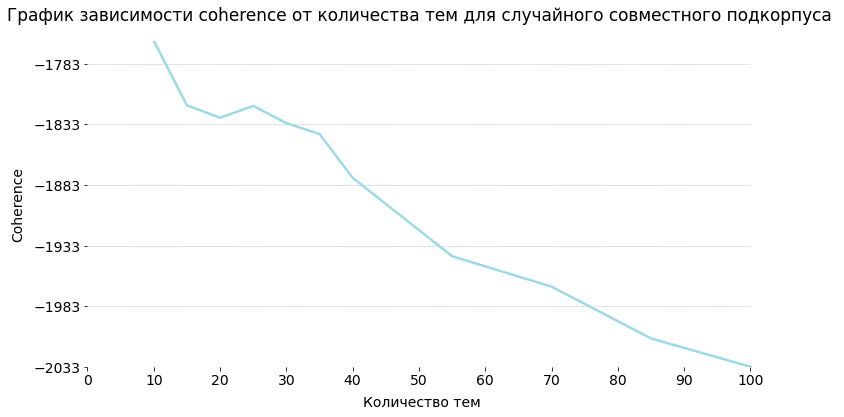

In [ ]:
plt.figure(figsize=(12,6))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

max_score = np.round(max(all_scores) + .05, 1)
min_score = np.round(min(all_scores) - .05, 1)

plt.ylim(min_score, max_score)    
plt.xlim(0, 101) 

plt.yticks(np.arange(min_score, max_score, 50), fontsize=14)    
plt.xticks(np.arange(0, 101, 10), fontsize=14) 

for y in np.arange(min_score, max_score, 50):    
    plt.plot(np.arange(0, 101), [y] * len(np.arange(0,101)), "--", lw=0.5, color="black", alpha=0.3) 
    
plt.tick_params(axis='both', which=False, bottom=False, top=False,    
                labelbottom=True, labeltop=False, left=False, right=False, labelleft=True)

r, g, b = (158, 218, 229)    
c = (r / 255., g / 255., b / 255.)

plt.plot(all_numbers, 
         all_scores, 
         lw=2.5, color=c)

plt.xlabel('Количество тем', fontsize=14, labelpad=8)
plt.ylabel('Coherence', fontsize=14, labelpad=8)

plt.title("График зависимости coherence от количества тем для случайного совместного подкорпуса ", fontsize=17, loc="center", pad=20) 
plt.show()

Кажется, будто с уменьшением количества тем модель стремится к наилучшему результату. Однако, как было описано в работе, еще не создано такой мтерики оценки тематической модели, которая бы идеально предсказывала человеческую. Проверим набор тем для лучшего значения метрики (n=10) и для значения в на уровне образовавшегося "локтя", где модель была относительно стабильна (n=30).

In [ ]:
lda1 = LdaModel(bow, id2word=d, num_topics=10, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
tfidf_sort(term_topic(lda1)).head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
Term 1,этап,федерация,экономика,экономический,час,член,чебоксары,факт,хотя,советский
Term 2,школьник,требование,фондовый,фонд,фото,украинский,хозяйство,установить,хотеть,русский
Term 3,школа,телефон,фон,финансовый,транспорт,украина,учреждение,уголовный,учёный,рука
Term 4,чемпионат,статья,торговый,тыс,температура,совет,участок,убийство,тува,родный
Term 5,фильм,срок,торг,счёт,станция,сила,строительство,теракт,стоить,рассказывать
Term 6,фестиваль,социальный,снизиться,сумма,самолёт,путин,руководитель,суд,специалист,праздник
Term 7,турнир,сайт,снижение,стоимость,происшествие,против,ремонт,следствие,решить,память
Term 8,третий,проверка,рынок,составлять,причина,председатель,региональный,следственный,просто,отечественный
Term 9,театр,право,рост,руб,правда,пост,рамка,расследование,поэтому,отец
Term 10,среди,правило,пункт,производство,пострадать,политический,проведение,прокуратура,помочь,музей


In [ ]:
lda2 = LdaModel(bow, id2word=d, num_topics=30, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
tfidf_sort(term_topic(lda2)).head(10)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,ярский,фронт,эксперт,цифровой,школьник,член,чувашский,трасса,цель,ярый,электроэнергия,этап,факт,сын,чистый,учёт,экипаж,штат,сутки,челябинск,штраф,фьючерс,январь,транспортный,юкос,футбол,хотя,фонд,ядерный,экология
Term 2,язык,статья,экономика,учёный,школа,украинский,чебоксары,трамвай,сфера,цвет,щенок,чемпион,установить,старший,увеличиться,требование,учение,франция,состояние,художник,судья,фондовый,церковь,транспорт,чиновник,тур,хотеть,финансы,трамп,экологический
Term 3,традиция,ссср,текущий,устройство,учиться,украина,участок,столкнуться,создать,трава,филиал,финал,убить,сосед,тариф,телефон,сила,террорист,скорый,форум,судебный,фон,храм,травма,фирма,сыграть,тува,трлн,терроризм,хозяйство
Term 4,творческий,советский,спрос,университет,учитель,совет,строительство,станция,создание,товар,сервис,физический,убийство,семья,сравнение,соответствие,самолёт,теракт,россиянин,фильм,суд,торг,тёплый,проспект,сумма,стадион,стоить,ставка,сотрудничество,туристический
Term 5,русский,потерять,снижение,технология,ученик,пост,слушание,скорость,региональный,сухой,сбербанк,турнир,совершить,рождение,расход,размер,рейс,северный,риск,увидеть,следствие,снизиться,туляк,происшествие,приобрести,состав,сразу,резерв,соглашение,турист
Term 6,произведение,поиск,сектор,способ,учебный,политический,ремонт,свет,реализация,собака,сайт,тренировка,следственный,проживать,прибыль,приём,ракета,против,режим,театр,свобода,сессия,тульский,пострадать,предприниматель,сезон,рука,погашение,совместный,туризм
Term 7,праздничный,пароль,рейтинг,современный,удмуртский,партия,реконструкция,путь,рамка,рыба,правда,тренер,следователь,преступный,период,плата,остров,передавать,распространение,спектакль,прокурор,сделка,тула,пожарный,платёж,ротор,решить,облигация,саудовский,тонна
Term 8,праздник,память,расти,ростелеком,удмуртия,парламент,расположить,полёт,поддержка,растение,офис,спортсмен,расследование,папа,оао,пенсия,оборона,официальный,препарат,состояться,прокуратура,ртс,температура,пожар,палестинский,поле,рассказывать,мвф,санкция,техника
Term 9,посвятить,отечественный,прогноз,разный,труд,палата,публичный,поезд,общественный,птица,отделение,спортивный,ранение,отец,квартал,пенсионный,море,оон,пациент,роль,проверка,роснефть,суббота,остановка,ооо,мяч,просто,курс,поставка,сельский
Term 10,песня,орден,падение,различный,студент,отставка,проведение,подземный,направление,продукт,оператор,спорт,правоохранительный,окно,доля,оплата,ливия,нато,медицинский,режиссёр,признать,пункт,сталинградский,огонь,налоговый,минута,поэтому,китайский,подписать,рабочий


Набор термов тем для n=30 показался нам лучше интрепретируемым, чем набор термов тем для n=10, так что мы остановились на значении n=30.

## Обучение и сохранение моделей

Данный раздел посвящен обучению и сохранению моделей. Сохранение моделей позволяет экономить время на повторном обучении в случае перезапуска прогарммы.

### Модель регионального корпуса

In [ ]:
path_regional = "/corpora/regional.csv"
reg_df = pd.read_csv(path_regional)['text']
r_pc = [[token for token in str(doc).split() if len(token)>2] for doc in reg_df]

In [ ]:
mkdir('models')

In [ ]:
r_d = Dictionary(r_pc)
r_d.filter_extremes(no_below=20, no_above=0.1)
r_d.compactify()
r_d.save_as_text("models/regional_dictionary.txt")

In [ ]:
r_d = Dictionary().load_from_text("models1/regional_dictionary.txt")

In [ ]:
r_bow = [r_d.doc2bow(text) for text in r_pc]
rls = [len(l) for l in r_bow]
print(sum(rls), np.mean(rls))

26839047 97.56744170829062


In [ ]:
regional = LdaModel(r_bow, id2word=r_d,
               num_topics=30, 
               random_state=0, 
               chunksize=1740, 
               alpha='auto', eta='auto', 
               iterations=500, passes=20, eval_every=None)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
temp_file = datapath(join("/content/gdrive/MyDrive/models1", "regional"))
regional.save(temp_file)

### Модель центрального корпуса

In [ ]:
path_central = "/corpora/cenral.csv"
centre_df = pd.read_csv(path_central)['text']

In [ ]:
c_pc = [[token for token in str(doc).split() if len(token)>2] for doc in centre_df]
c_d = Dictionary(c_pc)
c_d.filter_extremes(no_below=20, no_above=0.1)
c_d.compactify()
c_d.save_as_text("/models/central_dictionary.txt")

Ограничения оперативной памяти не позволяли нам создать BOW репрезентацию корпуса за один раз, поэтому с корпусом центральных СМИ пришлось работать инкрементально. Однако это послужило опытом знакомства с инструментами GenSim и дало понять, что его модно без особого труда использовать для мониторингв тем, при условии пополнения корпусов.

#### Первая четверть

In [ ]:
c_pc1 = c_pc[:int((len(c_pc))/4)]
c_pc1 = [[token for token in doc if token in c_d.token2id.keys()] for doc in c_pc1]
ls1 = [len(l) for l in c_pc1]
print(sum(ls1), np.mean(ls1))

8083039 160.8564975124378


In [ ]:
c_bow1 = [c_d.doc2bow(text) for text in c_pc1]
central = LdaModel(c_bow1, id2word=c_d,
               num_topics=30, 
               random_state=0, 
               chunksize=1740, 
               alpha='auto', eta='auto', 
               iterations=500, passes=20, eval_every=None)
temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_first_quarter"))
central.save(temp_file1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


#### Вторая четверть

In [ ]:
c_d = Dictionary.load_from_text('/content/gdrive/MyDrive/models1/central_dictionary.txt')

In [ ]:
c_pc2 = c_pc[int((len(c_pc)) / 4) : 2 * int((len(c_pc)) / 4)]
c_pc2 = [[token for token in doc if token in c_d.token2id.keys()] for doc in c_pc2]
ls2 = [len(l) for l in c_pc2]
print(sum(ls2), np.mean(ls2))

5345942 106.38690547263681


In [ ]:
c_bow2 = [c_d.doc2bow(text) for text in c_pc2]

temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_first_quarter"))
central = LdaModel.load(temp_file1)
central.update(c_bow2,
               chunksize=1740, 
               iterations=500, passes=20, eval_every=None)
temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_two_quarters"))
central.save(temp_file1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


#### Третья четверть

In [ ]:
c_d = Dictionary.load_from_text('/content/gdrive/MyDrive/models1/central_dictionary.txt')

In [ ]:
c_pc3 = c_pc[2 * int((len(c_pc)) / 4) : 3 * int((len(c_pc)) / 4)]
c_pc3 = [[token for token in doc if token in c_d.token2id.keys()] for doc in c_pc3]
ls3 = [len(l) for l in c_pc3]
print(sum(ls3), np.mean(ls3))

6908921 137.49096517412934


In [ ]:
c_bow3 = [c_d.doc2bow(text) for text in c_pc3]

temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_two_quarters"))
central = LdaModel.load(temp_file1)
central.update(c_bow3,
               chunksize=1740, 
               iterations=500, passes=20, eval_every=None)
temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_three_quarters"))
central.save(temp_file1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


#### Четвертая четверть

In [ ]:
c_d = Dictionary.load_from_text('/content/gdrive/MyDrive/models1/central_dictionary.txt')

In [ ]:
c_pc4 = c_pc[3 * int((len(c_pc)) / 4):]
c_pc4 = [[token for token in doc if token in c_d.token2id.keys()] for doc in c_pc4]
ls4 = [len(l) for l in c_pc4]
print(sum(ls4), np.mean(ls4))

6047409 120.33926332756253


In [ ]:
c_bow4 = [c_d.doc2bow(text) for text in c_pc4]

In [ ]:
temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_three_quarters"))
central = LdaModel.load(temp_file1)
central.update(c_bow4,
               chunksize=1740, 
               iterations=500, passes=20, eval_every=None)
temp_file1 = datapath(join("/content/gdrive/MyDrive/models1", "central_full"))
central.save(temp_file1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
c_bow_full = c_bow1.copy()
c_bow_full.extend(c_bow2)
c_bow_full.extend(c_bow3)
c_bow_full.extend(c_bow4)
pd.DataFrame(c_bow_full)
#c_bow_full.to_csv(join("/content/gdrive/MyDrive/models1", "c_bow.csv"),index=False)

## Два способа воссоздать модель

Для разных задач анализа могут понадобиться как модель полного корпуса, так и его части. Ниже приведены алгоритмы, позволяющие получить модели.

### Вариант 1: Создание моделей и словарей на основе случайных подвыборок корпусов

In [ ]:
path_central = "/corpora/central.csv"
centre_df = pd.read_csv(path_central)['text']

sample_size = 25000
c_pc = [[token for token in str(doc).split() if len(token)>2] for doc in centre_df.sample(n=sample_size, random_state=0)]

c_d = Dictionary(c_pc)
c_d.filter_extremes(no_below=15, no_above=0.6)
c_d.compactify()
c_bow = [c_d.doc2bow(text) for text in c_pc]

central = LdaModel(c_bow, id2word=c_d,
               num_topics=30, 
               random_state=0, 
               chunksize=1740, 
               alpha='auto', eta='auto', 
               iterations=500, passes=20, eval_every=None)

In [ ]:
path_regional = "/corpora/central.csv"
r_df = pd.read_csv(path_regional)['text']

sample_size = 25000
r_pc = [[token for token in str(doc).split() if len(token)>2] for doc in r_df.sample(n.sample_size, random_state=0)]

r_d = Dictionary(r_pc)
r_d.filter_extremes(no_below=15, no_above=0.6)
r_d.compactify()
r_bow = [r_d.doc2bow(text) for text in r_pc]

regional = LdaModel(r_bow, id2word=r_d,
               num_topics=30, 
              random_state=0, 
               chunksize=1740, 
               alpha='auto', eta='auto', 
               iterations=500, passes=20, eval_every=None)

### Вариант 2: Загрузка готовых моделей и словарей

In [ ]:
temp_file1 = datapath(join("models", "central_full"))
central = LdaModel.load(temp_file1)
c_d = Dictionary.load_from_text('models/central_dictionary.txt')

In [ ]:
path_central = "/corpora/central.csv"
centre_df = pd.read_csv(path_central)['text']
c_pc = [[token for token in str(doc).split() if len(token)>2] for doc in centre_df]
c_bow = [c_d.doc2bow(text) for text in c_pc[:int((len(c_pc))/4)]]
c_bow.extend([c_d.doc2bow(text) for text in c_pc[int((len(c_pc)) / 4) : 2 * int((len(c_pc)) / 4)]])
c_bow.extend([c_d.doc2bow(text) for text in c_pc[2 * int((len(c_pc)) / 4) : 3 * int((len(c_pc)) / 4)]])
c_bow.extend([c_d.doc2bow(text) for text in c_pc[3 * int((len(c_pc)) / 4):]])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
temp_file2 = datapath(join("models", "regional"))
regional = LdaModel.load(temp_file2)
r_d = Dictionary.load_from_text('models/regional_dictionary.txt')

In [ ]:
path_regional = "/corpora/central.csv"
r_df = pd.read_csv(path_regional)['text']
r_pc = [[token for token in str(doc).split() if len(token)>2] for doc in r_df]
r_bow = [r_d.doc2bow(text) for text in r_pc]

## Матрица термов и тем

### Данные, полученные из модели

Получим исходные матрицы термов тем, ранжированные в соответствии с вероятностным распределением, полученным в результате работы алгоритма LDA.

In [ ]:
r_tt = term_topic(regional)
#r_tt.to_csv('Темы региональных СМИ.csv')
r_tt

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,правительство,дорога,body,пункт,авария,вода,семья,предприятие,январь,удмуртия,продукт,голова,нужно,тула,правда,ида,война,акция,смоленский,уголовный,объект,сбербанк,право,конкурс,произойти,единый,команда,животное,фестиваль,волонтёр
Term2,поддержка,дорожный,медицинский,сельский,утром,снег,друг,компания,выплата,можгинский,хозяйство,смотреть,поэтому,час,квартира,праздник,великий,музей,мир,суд,строительство,банк,закон,образование,пострадать,депутат,игра,инвалид,театр,подозревать
Term3,социальный,движение,врач,онф,муж,газ,родитель,производство,автобус,удмуртский,продукция,вечерок,проблема,май,вечерний,архив,победа,площадка,москва,полиция,ремонт,сайт,лицо,детский,пожар,партия,матч,красноармейский,искусство,учёный
Term4,губернатор,автомобиль,пожарный,село,алкоголь,метр,жить,млн,размер,спорт,молоко,рука,какой,советский,волгоградец,сергей,ветеран,культура,московский,задержать,бочаров,услуга,нарушение,образовательный,мужчина,общественный,клуб,собака,культура,исследование
Term5,андрей,водитель,заболевание,отход,железнодорожный,температура,мама,тыс,пенсия,ижевск,питание,нога,например,центральный,деньга,имя,военный,форум,поволжский,преступление,благоустройство,телефон,гражданин,ростелеком,мчс,председатель,ижевский,домашний,песня,наука
Term6,президент,транспорт,больница,мусор,станция,погода,мой,бизнес,пенсионный,спортивный,молочный,глаз,именно,далее,оказаться,александр,отечественный,выставка,народ,мвд,здание,карта,документ,учреждение,женщина,удмуртский,футбол,опасный,зритель,доброволец
Term7,реализация,дтп,здоровье,населить,отряд,тепло,знать,рынок,возраст,можга,магазин,футбольный,любой,октябрь,однако,книга,память,гость,язык,отношение,детский,клиент,орган,школьник,мвд,удмуртия,чемпионат,реабилитация,концерт,загребин
Term8,задача,машина,пациент,поселение,аэропорт,прибор,молодой,объём,фонд,соревнование,растение,брага,считать,июнь,решить,история,герой,григоренко,русский,мужчина,сеть,сеть,договор,учиться,происшествие,бречалов,стадион,специальный,творческий,такси
Term9,встреча,транспортный,лечение,экологический,вокзал,дождь,хотеть,составить,социальный,среди,овощ,одежда,стоить,площадь,сергей,подарок,сталинградский,молодёжный,столица,возбудить,дзержинский,почта,требование,студент,травма,совет,арсенал,ветеринарный,фильм,научный
Term10,власть,маршрут,болезнь,деревня,пропасть,горячий,женщина,ооо,декабрь,игринский,семя,река,делать,апрель,обратиться,автор,армия,история,сша,свобода,площадка,интернет,проверка,класс,доставить,дума,счёт,пища,коллектив,волонтёрский


In [ ]:
c_tt = term_topic(central)
#c_tt.to_csv('Темы центральных СМИ.csv')
c_tt

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,ребёнок,долг,кабинет,теракт,взрыв,закон,бюджет,космический,сектор,суд,китай,палестинский,самолёт,здание,штат,партия,общество,нефть,учёный,начальник,тысяча,московский,выборы,ирак,руб,террорист,пункт,программа,грузия,доллар
Term2,женщина,белоруссия,море,заседание,задержать,депутат,экономика,генерал,автономия,чечня,ставка,россиянин,автомобиль,минувший,буш,афганистан,население,газ,земля,имя,авиакомпания,столица,путин,израиль,период,талиб,япония,проект,врач,великобритания
Term3,материал,большой,вода,рубль,полиция,госдума,доллар,корабль,бумага,преступление,палестина,палестинец,прокуратура,мэр,джордж,переговоры,лишь,поставка,исследование,друг,фирма,дорога,совет,боевик,законопроект,группировка,японский,создание,заболевание,германия
Term4,мужчина,театр,остров,уголовный,дом,документ,экономический,аппарат,среда,юкос,китайский,арафат,машина,предъявить,соединить,украина,очень,нефтяной,университет,известный,пятница,участок,право,операция,январь,здание,саммит,использование,наркотик,иран
Term5,газета,фильм,река,обвинение,местный,председатель,терроризм,командир,промышленность,иракский,агентство,грузинский,аэропорт,мчс,вашингтон,политический,подобный,тонна,специалист,тысяча,итальянский,движение,встреча,оон,фонд,бывший,турция,ввп,здоровье,курс
Term6,вечером,хороший,берег,адвокат,мвд,комиссия,доход,минобороны,клинтон,убийство,команда,посольство,правоохранительный,градус,ладен,войско,больший,завод,ущелие,жизнь,марка,возбудить,администрация,израильский,сумма,убить,резерв,создать,медицинский,евро
Term7,молодой,церемония,животное,арестовать,пострадать,комитет,снижение,станция,возрасти,кандидат,рейтинг,шарон,пассажир,температура,налог,руководство,стоить,акционер,последовать,решить,швейцария,станция,гражданин,оружие,оао,отставка,индекс,коалиция,праздник,европейский
Term8,интернет,премия,гора,судебный,обнаружить,орган,показатель,израильтянин,четверг,чеченский,наказание,ясир,катастрофа,сильный,пакистан,журналист,смочь,добыча,химический,должность,четверо,площадь,руководитель,война,продажа,семья,сессия,сеть,вирус,британский
Term9,конкурс,картина,лодка,миллион,житель,губернатор,валюта,кремль,сократиться,нтв,клуб,конституция,авария,трагедия,американец,позиция,количество,соглашение,наука,утром,приобретение,еэс,заместитель,вооружённый,размер,смерть,турецкий,технология,здравоохранение,санкция
Term10,реклама,актёр,собака,обвинять,улица,деятельность,торговый,полёт,опасение,незаконный,продать,парламентский,вертолёт,пострадать,налоговый,выразить,каждый,топливо,планета,история,модель,строительство,член,оборона,газпром,взять,закрытие,разработать,лечение,таможенный


### Отсортируем слова, релевантные для каждого топика, в зависимости от значений TF-IDF

Как уже было описано выше, такое распределение говорит о важности слова для модели, но не всегда удобно для глаз исследователя. Ранжируем списки термов топиков так, чтобы наверху были слова наиболее отличающие тему от остальных.

In [ ]:
#r_tt = pd.read_csv("/Темы региональных СМИ.csv", header=0, index_col=0)
r_tt_sorted = tfidf_sort(r_tt)
r_tt_sorted

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,сфера,трасса,сутки,экология,утром,электроэнергия,хотеться,цена,январь,ярослав,ярмарка,ёлка,считать,час,удаться,художник,честь,форум,язык,ход,строительство,электронный,управлять,школьный,тракторозаводский,член,футбол,хозяин,художественный,эксперимент
Term 2,совещание,транспортный,состояние,экологический,украсть,холодный,хотеть,уровень,фонд,этап,яйцо,цвет,стоить,центральный,сразу,храм,церковь,туризм,южный,факт,современный,телефон,требование,школьник,трагедия,совет,тур,специальный,фильм,ходатайство
Term 3,реализация,транспорт,режим,счётчик,станция,уборка,сын,тыс,февраль,турнир,хлеб,ходить,разный,утро,сосед,труд,фронт,проходить,чёрный,уголовный,система,сервис,срок,учиться,травма,собрание,тренер,собака,фестиваль,учёный
Term 4,путин,сторона,распространение,среда,смерть,тёплый,супруг,сумма,трудовой,третий,фермер,футбольный,происходить,тула,решить,традиция,сталинградский,представить,чебоксары,суд,ремонт,связь,соответствие,учитель,спасатель,секретарь,сыграть,смартфон,туляк,употребление
Term 5,президент,скорость,профилактика,село,смертельный,труба,семейный,стоимость,страховой,среди,урожай,футболист,поэтому,суббота,просьба,спектакль,сталинград,посетить,удмурт,статья,реконструкция,сбербанк,собственник,учебный,сообщение,предварительный,стадион,реабилитация,театральный,университет
Term 6,правительство,проезжий,препарат,свалка,самолёт,тепло,рассказывать,ставка,страхование,спортсмен,упаковка,удар,помочь,сентябрь,просить,праздничный,солдат,посвятить,твой,совершение,появиться,сайт,проверка,студент,случиться,политический,состав,реабилитационный,театр,тимофеев
Term 7,подчеркнуть,правило,пожарный,сбор,родственник,температура,прийти,составлять,рождение,спортивный,тонна,увидеть,подобный,птица,прийтись,почётный,слава,открыться,сша,следственный,построить,регистрация,право,сад,скр,партия,соперник,проба,творчество,такси
Term 8,поддержка,полоса,пациент,ресурс,путь,снег,помогать,составить,работодатель,спорт,товар,смотреть,очередь,понедельник,пока,подарок,сила,открытие,столица,свобода,планироваться,приём,постановление,ростелеком,руль,партийный,сборная,предмет,творческий,свидетель
Term 9,обеспечение,пешеходный,медицинский,пункт,пропасть,слой,отец,рынок,пособие,соревнование,семя,река,особенно,памятник,однако,николай,святой,отдых,смоленский,районный,отремонтировать,почтовый,помещение,ребята,происшествие,палата,поле,пища,танец,росгвардия
Term 10,население,пешеход,медик,природный,пост,свет,мой,руб,получать,сарапул,сельскохозяйственный,подняться,образ,октябрь,обратиться,любовь,православный,организовать,северный,признать,объект,почта,нарушение,профессия,произойти,комиссия,мяч,опасный,сцена,профессор


In [ ]:
#c_tt = pd.read_csv("/Темы центральных СМИ.csv", header=0, index_col=0)
c_tt_sorted = tfidf_sort(c_tt)
c_tt_sorted

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,телефонный,церемония,хозяин,услуга,час,фракция,экономический,ящик,экономист,юкос,швейцарский,ясир,судно,якобы,штат,франция,школа,энергетический,эксперимент,язык,швеция,участок,союз,ядерный,январь,убить,японский,электронный,уплата,фунт
Term 2,сайт,хороший,территориальный,уголовный,устройство,федерация,экономика,спутник,четверг,чечня,чемпионат,шарон,столкновение,эвакуировать,флорида,украина,хотя,энергетика,химический,утром,швейцария,транспортный,состояться,удар,фонд,убитый,япония,цель,счастие,тегеран
Term 3,рука,фильм,тело,теракт,улица,срок,увеличение,святой,торжественный,чеченский,футбольный,церковь,самолёт,чрезвычайный,уничтожить,руководство,стоить,электроэнергия,ущелие,судья,шведский,транспорт,состав,террористический,финансы,трое,энергосистема,технология,страховой,таможенный
Term 4,рождение,тони,спасти,телефон,удаться,соответствие,торговый,ракета,стабильный,хусейн,утвердить,хамас,рейс,трагедия,танк,ранение,среди,холдинг,учёный,советский,четверо,путь,совет,талибан,товар,террорист,фигурировать,тенденция,страдать,стерлинг
Term 5,родитель,театральный,собака,судебный,совершить,регион,торг,разбиться,среда,факт,уверенный,турист,прокурор,температура,соединить,призвать,смочь,флот,утечка,собираться,хакер,построить,сергей,солдат,тариф,талиб,угольный,сфера,респондент,санкция
Term 6,реклама,театр,сербский,совершенный,происшествие,проведение,терроризм,приморье,сократиться,усама,толчок,тбилиси,прокуратура,спасатель,собраться,политический,серьёзный,топливо,установить,скончаться,фирма,поезд,свобода,пожар,сравнение,сын,уведомить,специальный,продукт,провал
Term 7,ребёнок,сцена,река,собственность,преступник,председатель,темп,праздничный,слияние,убийство,ставка,стража,прибыть,сильный,родина,позиция,реформа,тонна,университет,русский,резервный,площадь,руководитель,оружие,снизиться,смерть,турция,создать,препарат,повлечь
Term 8,разговор,спектакль,птица,следствие,полиция,постановление,текущий,орбита,сектор,тюрьма,рейтинг,россиянин,предпринять,разрушить,пауэлла,поддержка,просто,так,специалист,проживать,пятница,объект,республика,операция,руб,сентябрь,турецкий,создание,прекрасный,пакистанский
Term 9,пол,роль,посетитель,рубль,полицейский,порядок,сокращение,новосибирск,рыночный,телекомпания,процентный,пребывание,правоохранительный,пропасть,пакистан,переговоры,причём,природный,рекорд,появиться,приобретение,мост,путин,оон,продукция,село,трубопровод,сеть,праздник,опознать
Term 10,писать,режиссёр,подводный,предоставление,ночью,парламент,снижение,направиться,рекордный,суд,продать,посольство,посадка,предъявить,налоговый,партия,практически,поставка,разбирательство,письмо,почта,московский,принятие,оборона,продажа,свидетель,сессия,реализация,питание,нидерланды


### TF-IDF coherence тем

Рассчитаем метрику TF-IDF coherence для сравнения топиков одноймодели между собой и для сравнения моделей.

In [ ]:
r_coherences = []
r_tfidf = tfidf_corpus(r_bow)
#np.savetxt("TF-IDF региональных СМИ.csv", r_tfidf, delimiter=",")
#r_tfidf = genfromtxt('TF-IDF региональных СМИ.csv', delimiter=',')
for c in r_tt_sorted.columns:
  r_coherences.append(topic_tfidf_coherence(r_tt_sorted[c].to_list(), dictionary=r_d, tfidf_corpus = r_tfidf, eps=0.01))
r_tt_sorted.loc['coherence'] = r_coherences
r_tt_sorted.to_csv('Темы региональных СМИ_sorted_coherence.csv',encoding='utf-8-sig')
r_tt_sorted

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,сфера,трасса,сутки,экология,утром,электроэнергия,хотеться,цена,январь,ярослав,ярмарка,ёлка,считать,час,удаться,художник,честь,форум,язык,ход,строительство,электронный,управлять,школьный,тракторозаводский,член,футбол,хозяин,художественный,эксперимент
Term 2,совещание,транспортный,состояние,экологический,украсть,холодный,хотеть,уровень,фонд,этап,яйцо,цвет,стоить,центральный,сразу,храм,церковь,туризм,южный,факт,современный,телефон,требование,школьник,трагедия,совет,тур,специальный,фильм,ходатайство
Term 3,реализация,транспорт,режим,счётчик,станция,уборка,сын,тыс,февраль,турнир,хлеб,ходить,разный,утро,сосед,труд,фронт,проходить,чёрный,уголовный,система,сервис,срок,учиться,травма,собрание,тренер,собака,фестиваль,учёный
Term 4,путин,сторона,распространение,среда,смерть,тёплый,супруг,сумма,трудовой,третий,фермер,футбольный,происходить,тула,решить,традиция,сталинградский,представить,чебоксары,суд,ремонт,связь,соответствие,учитель,спасатель,секретарь,сыграть,смартфон,туляк,употребление
Term 5,президент,скорость,профилактика,село,смертельный,труба,семейный,стоимость,страховой,среди,урожай,футболист,поэтому,суббота,просьба,спектакль,сталинград,посетить,удмурт,статья,реконструкция,сбербанк,собственник,учебный,сообщение,предварительный,стадион,реабилитация,театральный,университет
Term 6,правительство,проезжий,препарат,свалка,самолёт,тепло,рассказывать,ставка,страхование,спортсмен,упаковка,удар,помочь,сентябрь,просить,праздничный,солдат,посвятить,твой,совершение,появиться,сайт,проверка,студент,случиться,политический,состав,реабилитационный,театр,тимофеев
Term 7,подчеркнуть,правило,пожарный,сбор,родственник,температура,прийти,составлять,рождение,спортивный,тонна,увидеть,подобный,птица,прийтись,почётный,слава,открыться,сша,следственный,построить,регистрация,право,сад,скр,партия,соперник,проба,творчество,такси
Term 8,поддержка,полоса,пациент,ресурс,путь,снег,помогать,составить,работодатель,спорт,товар,смотреть,очередь,понедельник,пока,подарок,сила,открытие,столица,свобода,планироваться,приём,постановление,ростелеком,руль,партийный,сборная,предмет,творческий,свидетель
Term 9,обеспечение,пешеходный,медицинский,пункт,пропасть,слой,отец,рынок,пособие,соревнование,семя,река,особенно,памятник,однако,николай,святой,отдых,смоленский,районный,отремонтировать,почтовый,помещение,ребята,происшествие,палата,поле,пища,танец,росгвардия
Term 10,население,пешеход,медик,природный,пост,свет,мой,руб,получать,сарапул,сельскохозяйственный,подняться,образ,октябрь,обратиться,любовь,православный,организовать,северный,признать,объект,почта,нарушение,профессия,произойти,комиссия,мяч,опасный,сцена,профессор


In [ ]:
c_coherences = []
c_tfidf = tfidf_corpus(c_bow)
#np.savetxt("TF-IDF центральных СМИ.csv", r_tfidf, delimiter=",")
#r_tfidf = genfromtxt('TF-IDF центральных СМИ.csv', delimiter=',')
for c in c_tt_sorted.columns:
  c_coherences.append(topic_tfidf_coherence(c_tt_sorted[c].to_list(), dictionary=c_d, tfidf_corpus = c_tfidf, eps=0.01))
c_tt_sorted.loc['coherence'] = c_coherences
c_tt_sorted.to_csv('Темы центральных СМИ_sorted_coherence.csv',encoding='utf-8-sig')
c_tt_sorted

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,телефонный,церемония,хозяин,услуга,час,фракция,экономический,ящик,экономист,юкос,швейцарский,ясир,судно,якобы,штат,франция,школа,энергетический,эксперимент,язык,швеция,участок,союз,ядерный,январь,убить,японский,электронный,уплата,фунт
Term 2,сайт,хороший,территориальный,уголовный,устройство,федерация,экономика,спутник,четверг,чечня,чемпионат,шарон,столкновение,эвакуировать,флорида,украина,хотя,энергетика,химический,утром,швейцария,транспортный,состояться,удар,фонд,убитый,япония,цель,счастие,тегеран
Term 3,рука,фильм,тело,теракт,улица,срок,увеличение,святой,торжественный,чеченский,футбольный,церковь,самолёт,чрезвычайный,уничтожить,руководство,стоить,электроэнергия,ущелие,судья,шведский,транспорт,состав,террористический,финансы,трое,энергосистема,технология,страховой,таможенный
Term 4,рождение,тони,спасти,телефон,удаться,соответствие,торговый,ракета,стабильный,хусейн,утвердить,хамас,рейс,трагедия,танк,ранение,среди,холдинг,учёный,советский,четверо,путь,совет,талибан,товар,террорист,фигурировать,тенденция,страдать,стерлинг
Term 5,родитель,театральный,собака,судебный,совершить,регион,торг,разбиться,среда,факт,уверенный,турист,прокурор,температура,соединить,призвать,смочь,флот,утечка,собираться,хакер,построить,сергей,солдат,тариф,талиб,угольный,сфера,респондент,санкция
Term 6,реклама,театр,сербский,совершенный,происшествие,проведение,терроризм,приморье,сократиться,усама,толчок,тбилиси,прокуратура,спасатель,собраться,политический,серьёзный,топливо,установить,скончаться,фирма,поезд,свобода,пожар,сравнение,сын,уведомить,специальный,продукт,провал
Term 7,ребёнок,сцена,река,собственность,преступник,председатель,темп,праздничный,слияние,убийство,ставка,стража,прибыть,сильный,родина,позиция,реформа,тонна,университет,русский,резервный,площадь,руководитель,оружие,снизиться,смерть,турция,создать,препарат,повлечь
Term 8,разговор,спектакль,птица,следствие,полиция,постановление,текущий,орбита,сектор,тюрьма,рейтинг,россиянин,предпринять,разрушить,пауэлла,поддержка,просто,так,специалист,проживать,пятница,объект,республика,операция,руб,сентябрь,турецкий,создание,прекрасный,пакистанский
Term 9,пол,роль,посетитель,рубль,полицейский,порядок,сокращение,новосибирск,рыночный,телекомпания,процентный,пребывание,правоохранительный,пропасть,пакистан,переговоры,причём,природный,рекорд,появиться,приобретение,мост,путин,оон,продукция,село,трубопровод,сеть,праздник,опознать
Term 10,писать,режиссёр,подводный,предоставление,ночью,парламент,снижение,направиться,рекордный,суд,продать,посольство,посадка,предъявить,налоговый,партия,практически,поставка,разбирательство,письмо,почта,московский,принятие,оборона,продажа,свидетель,сессия,реализация,питание,нидерланды


# Эксперимент 2: TF-IDF кластеризация

Попробуем произвести выделение тем с помощью кластеризации текстов, векторизованных с помощью модели TF-IDF.

In [ ]:
path_regional = "/corpora/regional.csv"
r_df = pd.read_csv(path_regional)['text']
r_tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False, min_df = 3, max_df = 0.95)
r_tfidf_vec = r_tfidf.fit_transform(r_df.dropna())

In [ ]:
path_central = "/corpora/central.csv"
centre_df = pd.read_csv(path_central)['text']
c_tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False, min_df = 3, max_df = 0.95)
c_tfidf_vec = c_tfidf.fit_transform(centre_df.dropna())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


В нашей работе используется алгоритм K-menas, требующий заранее указать, сколько кластеров мы хотим обнаружить. Подберем это значение. Суть работы алгоритма сводится к минимизации значения квадратичной ошибки, поэтому будем визуализировать зависимость значения остаточной суммы квадров от количества кластеров. Обычно оптимальное количество принято выделять по моменту, когда модель стабилизируется, по появлению "локтя" ближе к нижней част графика.

In [ ]:
def choose_n_clusters(data, max_k, name_of_corpus = 'СМИ'):
  sse = []
  for k in range(2, max_k+1, 2):
    sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))
  ax.spines["top"].set_visible(False)    
  ax.spines["bottom"].set_visible(False)    
  ax.spines["right"].set_visible(False)    
  ax.spines["left"].set_visible(False) 
  ax.plot(range(2, max_k+1, 2), sse, marker='o', color='black')
  ax.set_xlabel('Cluster Centers')
  ax.set_xticks(range(2, max_k+1, 2))
  ax.set_xticklabels(range(2, max_k+1, 2))
  ax.set_ylabel('Остаточная сумма квадратов')
  ax.set_title('График ависимости остаточной суммы квадратов от количества кластеров для корпуса {}'.format(name_of_corpus))

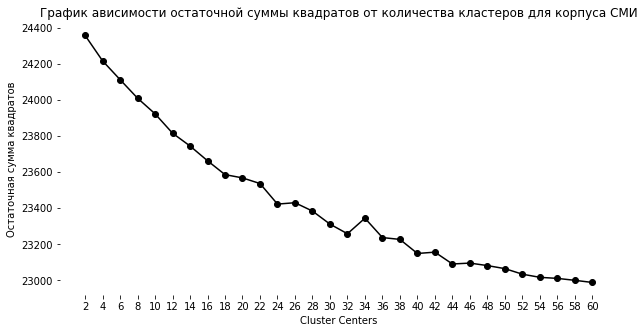

In [ ]:
choose_n_clusters(r_tfidf_vec, 60)

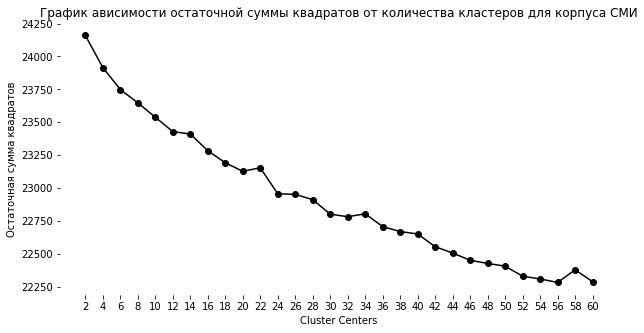

In [ ]:
choose_n_clusters(c_tfidf_vec, 60)

Для наших данных значение ошибки перестает падать постепенно, ярко выженного "локтя" не видно. Для нашей работы мы реишили использовать занчение количество кластеров, равное 30, так как ошибка при этом уже ближе к минимальной, чем к максимальной, а такое значение позволит легче провести сравнение модели кластеризации и алгоритма LDA, где ранее был выбран тако же параметр.

In [ ]:
def tfidf_clustering(tfidf_vec, n_clusters):
  kmeans = MiniBatchKMeans(n_clusters=n_clusters, init_size=1024, batch_size=2048, random_state=0)
  return kmeans.fit_predict(tfidf_vec)

In [ ]:
def plot_tsne_pca(data, labels):
  max_label = max(labels)
  max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
  
  pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
  tsne = TSNE().fit_transform(PCA(n_components=42).fit_transform(data[max_items,:].todense()))
  
  idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
  label_subset = labels[max_items]
  label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
  
  f, ax = plt.subplots(1, 2, figsize=(14, 6))
  
  ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
  ax[0].set_title('PCA Cluster Plot')
  
  ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
  ax[1].set_title('TSNE Cluster Plot')

def keywords(data, clusters, feature_names, n_terms):
  df = pd.DataFrame(data.todense()).groupby(clusters).mean()
  res = [[feature_names[t] for t in np.argsort(r)[-n_terms:]] for i,r in df.iterrows()]
  df_res = pd.DataFrame(np.array(res).T,
                        index=['Term {}'.format(i) for i in range(1, n_terms+1)], 
                        columns = ['Topic {}'.format(i) for i, _ in df.iterrows()])
  return df_res

Построим и визуализируем кластеры с помощью методов уменьшения размерности.

In [ ]:
r_labels = tfidf_clustering(r_tfidf_vec, 30)
c_labels = tfidf_clustering(c_tfidf_vec, 30)

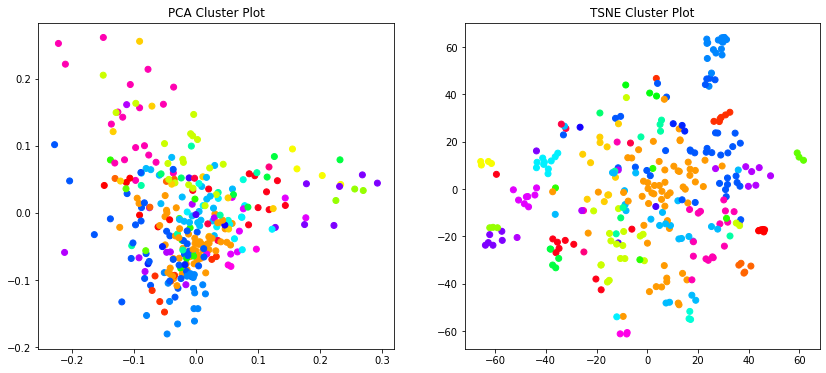

In [ ]:
plot_tsne_pca(r_tfidf_vec, r_labels)

Как видим, совсем обособленных кластеров модель не выделила, однакозаметны определенные скопления. Особенно хорошо это показвает график кластеров, основанный на TSNE.

In [ ]:
r_keywords = keywords(r_tfidf_vec, r_labels, r_tfidf.get_feature_names(), 30)
r_keywords = tfidf_sort(r_keywords)

r_keywords.to_csv('Tfidf_keywords_regional.csv',encoding='utf-8-sig')
r_keywords

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,чиновник,труппа,ставка,самый,ремонт,сообщение,штраф,случиться,ставрополье,цена,южный,ук,чувашский,признать,штаб,чп,челябинск,чемпионат,хороший,экспонат,холодный,щенок,трасса,учреждение,худенко,цельсий,федеральный,телефонный,троллейбус,факт
Term 2,тувинский,театральный,сервис,сам,проспект,сгореть,требование,сбить,сложность,тыс,юво,судить,чебоксары,приговор,число,указать,текслера,футбол,участник,экспозиция,тулагорводоканал,хозяин,столкнуться,социальный,фото,термометр,строительство,представиться,транспортный,убийство
Term 3,тува,театр,сбербанк,работать,подрядчик,расчёт,рф,пешеход,связьподать,товар,экипаж,ранее,чебоксарский,осудить,сутки,красноармейский,режим,турнир,участие,экскурсия,советский,спасти,столкновение,семья,торновый,температура,реализация,потерпевший,трамвайный,тело
Term 4,рт,сцена,сайт,очень,отремонтировать,причина,размер,переходить,регистрация,стоимость,учение,преступление,слушание,наказание,скончаться,июнь,избирательный,тренер,удмуртия,художник,пр,собака,очевидец,сад,тимофеев,столбик,развитие,позвонить,трамвай,су
Term 5,политический,спектакль,поволжский,один,благоустройство,потушить,прокуратура,пассажирка,разработать,средний,условный,похитить,публичный,лишение,последний,июль,голосование,стадион,принять,увидеть,подача,пёс,машина,родитель,сергей,снег,производство,перевести,станция,следственный
Term 6,партия,роль,офис,нужно,транспорт,поступить,проверка,напротив,потерять,среднее,техника,полицейский,проведение,колония,подтвердить,дзержинский,общественный,спортсмен,праздник,представить,пересечение,птица,гибдд,ребёнок,правда,синоптик,предприятие,пенсионерка,скоростной,скр
Term 7,парламент,режиссёр,отделение,мочь,территория,пожарный,организация,ехать,поиск,спрос,танк,подозревать,номер,дюмин,пневмония,вечерний,вопрос,спорт,победитель,посетитель,отключить,приют,врезаться,образование,поляничко,секунда,отметить,обратиться,рейс,пропасть
Term 8,ооржак,пьеса,операция,каждый,дорожный,пожар,нарушение,доставить,подпискузадать,составить,стрельба,отношение,местоположение,виновный,пациент,сегодня,территория,соревнование,мероприятие,посвятить,отключение,питомец,ваз,многодетный,марина,прогреться,задача,неизвестный,расписание,обнаружить
Term 9,народ,премьера,онлайн,жизнь,ул,пламя,лицо,госпитализировать,пароль,снизиться,соединение,кража,м,алексей,оперативный,пройти,челябинский,соперник,конкурс,открыться,окончание,отлов,пассажир,мама,кирилл,порыв,бочаров,мошенничество,путь,находиться
Term 10,кызыл,постановка,млрд,другой,объект,огонь,компания,травма,объявлениеоформить,рынок,противник,изъять,кв,губернатор,лечение,автор,выборы,сезон,акция,музейный,ограничить,любимец,травма,малыш,каширский,погода,андрей,мошенница,поезд,наркотик


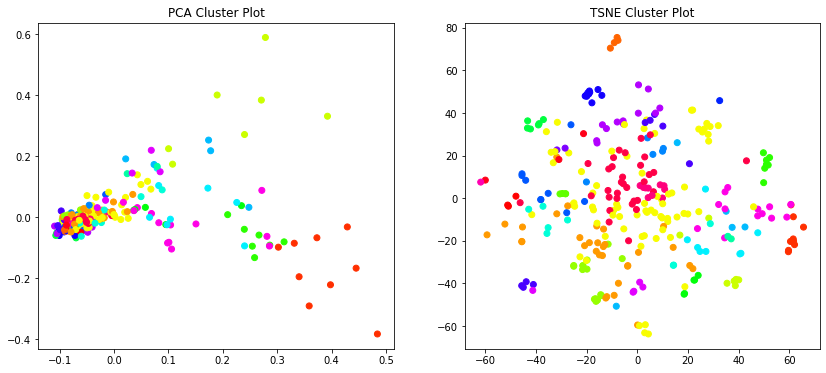

In [ ]:
plot_tsne_pca(c_tfidf_vec, c_labels)

In [ ]:
c_keywords = keywords(c_tfidf_vec, c_labels, c_tfidf.get_feature_names(), 30)
c_keywords = tfidf_sort(c_keywords)

c_keywords.to_csv('Tfidf_keywords_central.csv',encoding='utf-8-sig')
c_keywords

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
Term 1,хусейн,торговый,этаж,путин,среда,тыс,чистый,цик,триполи,фьючерс,установленный,тот,югославский,центробанк,штат,экономический,фонд,юкос,чечня,циклон,шахта,южный,экспедиция,поезд,транзит,сделка,ясир,эксперимент,фильм,член
Term 2,солдат,сектор,эвакуировать,министр,пятница,московский,увеличиться,рада,совет,спрос,укрепление,самолёт,югославия,составлять,трамп,экономика,федеральный,судья,усама,тёплый,устройство,факт,шаттл,машина,сторона,политика,хезболл,частица,театр,флот
Term 3,саддам,ртс,центр,иран,повышение,быть,убыток,президентский,резолюция,опек,сегодня,рейс,тюрьма,сбербанк,соединить,фрс,трлн,судебный,уничтожить,термометр,сработать,управление,челнок,землетрясение,природный,металл,хамас,учёный,смерть,теплоход
Term 4,представитель,пункт,тушение,должный,открыться,стать,ранее,председатель,полковник,нефтяной,рубль,разбиться,трибунал,резерв,санкция,темп,сумма,срок,убить,тепло,ранение,тбилиси,старт,дтп,поток,инвестор,фатх,университет,самый,танкер
Term 5,передавать,нефть,сгореть,государство,открытие,работа,прибыль,пост,повстанец,мировой,официальный,посадка,срю,кризис,обама,прогноз,рублёвый,следствие,террористический,температура,прогреметь,следственный,станция,дорога,подписать,еврооблигация,территория,такой,режиссёр,судный
Term 6,командование,ммвб,расчёт,вопрос,личный,проект,полугодие,политический,независимость,золото,ниже,пилот,слободан,кредитный,конгресс,потребительский,расход,свобода,террорист,суббота,взрывной,скп,спутник,движение,нефтегаз,динамика,пна,система,ребёнок,судно
Term 7,иракский,котировка,потушить,владимир,вторник,первый,период,партия,нато,запас,курс,пассажирский,сербский,кредит,дональд,месяц,погашение,признать,талибан,столица,взрыв,осетия,союз,водитель,месторождение,оао,палестинский,робот,полиция,спасательный
Term 8,иракец,индекс,пожарный,ядерный,ведущий,область,отчётный,парламентский,мятежник,добыча,корзина,лайнер,серб,капитал,джордж,инфляция,офз,приговорить,талиб,снег,бомба,милиция,роскосмос,вертолёт,куб,облигация,палестинец,помощь,однако,сомалийский
Term 9,ирак,бумага,пожар,украинский,premarket,отметить,отчёт,парламент,муаммар,бензин,копейка,катастрофа,мтбь,золотовалютный,вашингтон,годовой,остаток,приговор,спецоперация,синоптик,получить,мвд,ракета,автомобиль,контракт,неделя,палестина,поверхность,один,сомали
Term 10,война,фондовый,площадь,решение,финансы,главное,операционный,кандидатура,ливия,барра,копа,истребитель,милошевич,втб,буш,ввп,ликвидность,обвинять,республика,прогреться,орган,комитет,прогресс,автобус,газпром,продажа,обстрел,планета,мужчина,пролив


# О чем пишут в региональных и центральных СМИ: результаты и анализ

In [ ]:
#r_topics = pd.read_csv('results/Темы региональных СМИ_sorted_coherence.csv', index_col=0).iloc[:-1]
#c_topics = pd.read_csv('results/Темы центральных СМИ_sorted_coherence.csv', index_col=0).iloc[:-1]
#r_keywords = pd.read_csv('results/Tfidf_keywords_regional.csv', index_col=0)
#c_keywords = pd.read_csv('results/Tfidf_keywords_central.csv', index_col=0)

r_topics = r_tt_sorted.iloc[:-1]
c_topics = c_tt_sorted.iloc[:-1]

## Графы пересечения тем

 Чтобы сравнить структурные особенности содеражния центральных и региональных новостных потоков, посмотрим какие из тем среди двух коллекций пересекаются (содержат одно или больше общее слово). Созданные ниже функции могут принимать разные значения порога (как минимум сколько слов должны совпадать в темах), что позволяет удоьно с помощью визуализации изучить структуру связей топиков. В данной работе мы учитывали любые пары топиков, пересекающиеся хотя бы в одном слове.

In [ ]:
def topic_intersection_graph(topics_df1, topics_df2, thr = 0):
  topics = topics_df1.to_numpy().T
  topics = np.append(topics, topics_df2.to_numpy().T, axis=0)
  s = (topics.shape[0], topics.shape[0])
  m = np.zeros(s)
  topic1 = []
  topic2 = []
  intersection = []
  for i in range(topics.shape[0]):
    for j in range(i+2, topics.shape[0]):
      inter = np.intersect1d(topics[i,:], topics[j,:])
      if len(inter) > thr:
        
        if i<30:
          topic_i = 'R_{}'.format(i+1)
        else:
          topic_i = 'C_{}'.format(i-29)
        if j<30:
          topic_j = 'R_{}'.format(j+1)
        else:
          opic_j = 'C_{}'.format(j-29)
        topic1.append(topic_i)
        topic2.append(topic_j)
        intersection.append(' '.join(np.intersect1d(topics[i,:], topics[j,:])))
  return pd.DataFrame({'from':topic1,
                       'to':topic2,
                       'inter':intersection})

def build_graph(df):
  G = nx.Graph()
  for i in range(df.shape[0]):
    row = df.iloc[i]
    if row['from'] not in G.nodes():
      G.add_node(row['from'])
    if row['to'] not in G.nodes():
      G.add_node(row['to'])
    G.add_edge(row['from'], row['to'], dist = 1/len(row['inter'].split()))
  return G

def build_draw_inter_graph(df_inter, name='Intersection'):
  G_inter = build_graph(df_inter)
  plt.figure(figsize=(15,10))
  n = G_inter.number_of_nodes()
  pos = nx.spring_layout(G_inter, k=2/n**(1/2))

  nodecolors = ['skyblue' if node.startswith('C') else 'violet' for node in G_inter.nodes()]
  nx.draw_networkx_nodes(G_inter, pos, node_color=nodecolors, node_size=1500, node_shape="s")
  nx.draw_networkx_edges(G_inter, pos, width=1.0, alpha=0.5)

  #nx.draw(G_r, pos=pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
  nx.draw_networkx_labels(G_inter, pos, font_size=16)

  plt.title(name)
  plt.savefig(name+'.png')
  plt.show()

### Графики пересечения тем LDA

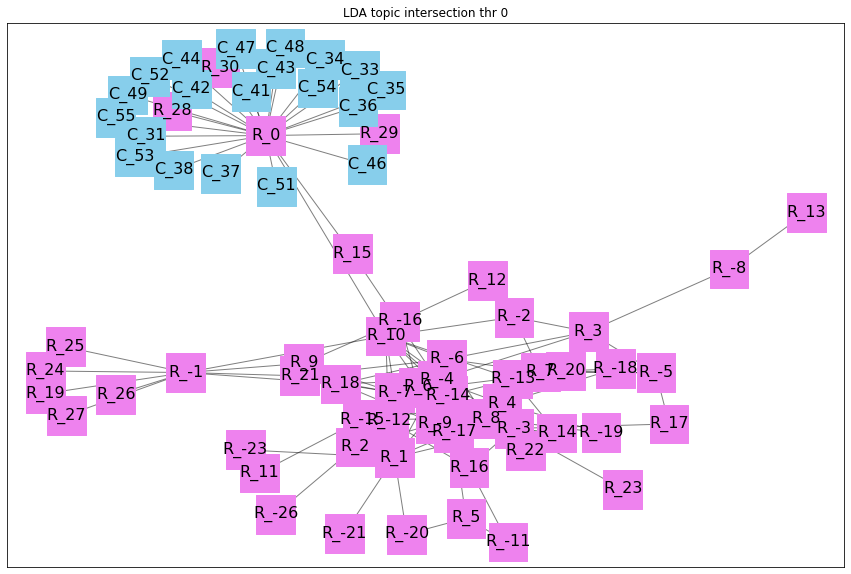

In [ ]:
thr=0
df_inter = topic_intersection_graph(r_topics, c_topics, thr=thr)
df_inter.to_csv('LDA_intersection_000.csv',encoding='utf-8-sig')
build_draw_inter_graph(df_inter, 'LDA topic intersection thr 0.0')

### Графики пересечения кластеров-тем TF-IDF кластеризации

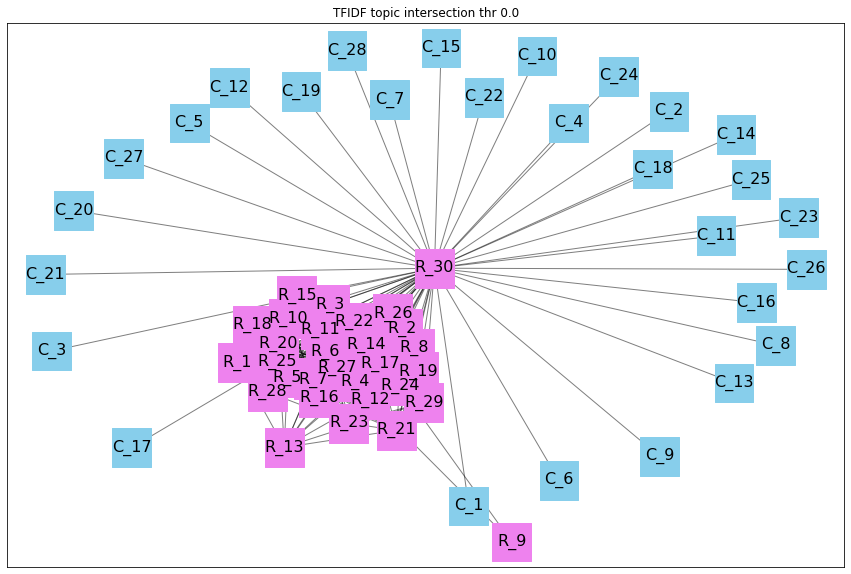

In [ ]:
thr=0
df_inter = topic_intersection_graph(r_keywords, c_keywords, thr=thr)
df_inter.to_csv('TFIDFintersection1.csv',encoding='utf-8-sig')
build_draw_inter_graph(df_inter, 'TFIDF topic intersection thr 0.0')